# ***KNN***

In [1]:
# ============================
# IMPORTS
# ============================
import os
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import random
import plotly.express as px

from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, log_loss, roc_auc_score, roc_curve, auc
)

import lime.lime_tabular
import time

import optuna
from optuna.pruners import MedianPruner
import optuna.visualization as vis
from sklearn.preprocessing import LabelEncoder

from reporte_metricas import ReporteMetricas
reporte = ReporteMetricas()
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from reporte_metricas import ReporteMetricas
reporte = ReporteMetricas()

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
optuna.logging.set_verbosity(optuna.logging.WARNING)

/Users/sergiosilveramurcia/Conda/miniconda3/envs/MachineLearning/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# =======================
# LOAD DATA
# =======================
file_path = "../Datos_Saber_Pro_Preprocesed.csv"
df = pd.read_csv(file_path)
X = df.drop(columns=["MOD_INGLES_DESEM"])
y = df["MOD_INGLES_DESEM"]

categorical_features = X.select_dtypes(include='object').columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [3]:
le = LabelEncoder()
y = pd.Series(le.fit_transform(y), index=y.index)

class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Class mapping:", class_mapping)

Class mapping: {'-A1': np.int64(0), 'A1': np.int64(1), 'A2': np.int64(2), 'B1': np.int64(3), 'B2': np.int64(4)}


In [4]:
# # ============================
model_filename = "../Models/best_knn_model_.pkl"
metrics_filename = "../Models/best_knn_metrics_.pkl"
fold_metrics_filename = "./Metrics/knn_folds_summary_.csv"

In [5]:
# ============================
# EVALUATION FUNCTION
# ============================
def evaluate_model(model, X_data, y_data):
    y_pred = model.predict(X_data)
    y_proba = model.predict_proba(X_data)
    f1 = f1_score(y_data, y_pred, average='weighted')
    acc = accuracy_score(y_data, y_pred)
    loss = log_loss(y_data, y_proba)
    auc = roc_auc_score(y_data, y_proba, multi_class='ovr', average='weighted')
    report = classification_report(y_data, y_pred)
    cm = confusion_matrix(y_data, y_pred)
    return f1, acc, loss, auc, report, cm, y_proba, y_pred

In [6]:
# ============================
# BUILD PIPELINE
# ============================
def build_pipeline(params, numeric_features, categorical_features):
    preprocessor = ColumnTransformer([
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), numeric_features),
        ('cat', Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='Sin Dato')),
                          ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), categorical_features)
    ],
        verbose_feature_names_out=False,
        force_int_remainder_cols=False
    )

    model = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=SEED)), 
        ('classifier', KNeighborsClassifier(**params))
    ])
    return model

In [7]:
# ============================
# FOLD METRIC SAVER
# ============================
def save_metrics_folds(folds_metrics: list, filename: str) -> pd.DataFrame:
    df = pd.DataFrame(folds_metrics)
    metric_cols = df.columns.drop('fold') if 'fold' in df.columns else df.columns
    mean_row = df[metric_cols].mean().to_dict()
    std_row = df[metric_cols].std().to_dict()
    mean_row['fold'] = 'mean'
    std_row['fold'] = 'std'
    df_final = pd.concat([df, pd.DataFrame([mean_row, std_row])], ignore_index=True)
    df_final.to_csv(filename, index=False)
    print(f"\n📁 Fold metrics + summary saved to: {filename}")
    return df_final

# ============================
# CONFUSION MATRIX PLOTTER
# ============================
def plot_confusion_matrix(cm, labels, title):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.show()

In [8]:
# ============================
# OPTUNA INNER CV OPTIMIZATION
# ============================
def run_inner_optuna(X_inner, y_inner, numeric_features, categorical_features, n_trials=75):
    def objective(trial):
        params = {
            "n_neighbors": trial.suggest_int("n_neighbors", 10, 50, step=5),
            "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
            "metric": trial.suggest_categorical("metric", ["euclidean", "manhattan"])
        }
        
        model = build_pipeline(params, numeric_features, categorical_features)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
        scores = []
        
        for train_idx, val_idx in skf.split(X_inner, y_inner):
            X_t, X_v = X_inner.iloc[train_idx], X_inner.iloc[val_idx]
            y_t, y_v = y_inner.iloc[train_idx], y_inner.iloc[val_idx]
            model.fit(X_t, y_t)
            y_pred = model.predict(X_v)
            scores.append(f1_score(y_v, y_pred, average='weighted'))
        return np.mean(scores)

    study = optuna.create_study(direction="maximize", pruner=MedianPruner())
    study.optimize(objective, n_trials=n_trials)
    return study.best_params, study

In [9]:
# ============================
# NESTED CV
# ============================
def nested_cv(X: pd.DataFrame, y: pd.Series, numeric_features: list, categorical_features: list):
    all_folds_metrics = []

    if os.path.exists(model_filename) and os.path.exists(metrics_filename):
        best_model = joblib.load(model_filename)
        best_metrics = joblib.load(metrics_filename)
        return best_model, best_metrics

    optuna_studies = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    best_f1 = -np.inf
    best_model = None
    best_metrics = {}

    for fold, (train_idx, test_idx) in tqdm(enumerate(outer_cv.split(X, y), 1), total=outer_cv.get_n_splits(), desc="Training folds"):
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train_fold, y_train_fold, test_size=0.2, stratify=y_train_fold, random_state=SEED
        )

        start_time = time.time()
        best_params, study = run_inner_optuna(X_tr, y_tr, numeric_features, categorical_features)
        elapsed = time.time() - start_time

        optuna_studies.append(study)

        model = build_pipeline(best_params, numeric_features, categorical_features)
        model.fit(X_tr, y_tr)

        f1_train, acc_train, loss_train, auc_train, report_train, cm_train, y_proba_train, y_train_pred = evaluate_model(model, X_tr, y_tr)
        f1_val, acc_val, loss_val, auc_val, report_val, cm_val, y_proba_val, y_val_pred = evaluate_model(model, X_val, y_val)
        f1_test, acc_test, loss_test, auc_test, report_test, cm_test, y_proba_test, y_test_pred = evaluate_model(model, X_test_fold, y_test_fold)

        fold_metrics = {
            "fold": fold,
            "f1_train": f1_train,
            "accuracy_train": acc_train,
            "log_loss_train": loss_train,
            "auc_train": auc_train,
            "f1_val": f1_val,
            "accuracy_val": acc_val,
            "log_loss_val": loss_val,
            "auc_val": auc_val,
            "f1_test": f1_test,
            "accuracy_test": acc_test,
            "log_loss_test": loss_test,
            "auc_test": auc_test,
            "optuna_time": elapsed
        }
        all_folds_metrics.append(fold_metrics)

        if f1_test > best_f1:
            best_f1 = f1_test
            best_model = model
            best_metrics = {
                **fold_metrics,
                "params": best_params,
                "labels": np.unique(y),
                "best_fold": fold - 1,
                "X_train_fold": X_tr,
                "y_train_fold": y_tr,
                "y_train_pred": y_train_pred,
                "y_train_true": y_tr,
                "y_proba_train": y_proba_train,
                "classification_report_train": report_train,
                "confusion_matrix_train": cm_train,
                "y_val_true": y_val,
                "y_val_pred": y_val_pred,
                "y_proba_val": y_proba_val,
                "classification_report_val": report_val,
                "confusion_matrix_val": cm_val,
                "y_test_fold": y_test_fold,
                "y_test_pred": y_test_pred,
                "y_proba_test": y_proba_test,
                "classification_report_test": report_test,
                "confusion_matrix_test": cm_test
            }

    joblib.dump(best_model, model_filename)
    joblib.dump(best_metrics, metrics_filename)
    df_folds = save_metrics_folds(all_folds_metrics, fold_metrics_filename)

    return best_model, best_metrics

In [10]:
model, metrics = nested_cv(X, y, numeric_features, categorical_features)

In [11]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Sin '
                                                                                            'Dato',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=F...
                                                   'INST_CARACTER_ACADEMICO',
                                                   'INST_ORIGEN', 'ESTU_GENERO',
                                                   'ESTU_NACIONALIDAD',
                                                   'ESTU_HORASSEMANATRABAJA',
                                                   'ESTU_PAGOMATRICULABECA',
                                                   'ESTU_PAGOMATRICULACREDITO',
                                                   'ESTU_PAGOMATRICULAPADRES',
                                                   'ESTU_PAGOMATRICULAPROPIO',
                                                   'ESTU_DEPTO_RESIDE',
                                                   'ESTU_DEPTO_PRESENTACION'])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=30))])

In [12]:
print(metrics['classification_report_val'])

              precision    recall  f1-score   support

           0       0.38      0.07      0.12      4912
           1       0.36      0.25      0.30     11151
           2       0.45      0.70      0.55     20223
           3       0.40      0.31      0.35     11565
           4       0.54      0.39      0.45      5306

    accuracy                           0.44     53157
   macro avg       0.43      0.35      0.36     53157
weighted avg       0.42      0.44      0.40     53157



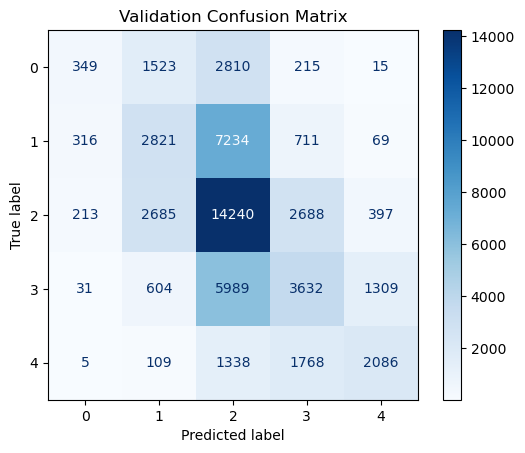

In [13]:
plot_confusion_matrix(metrics['confusion_matrix_val'], metrics['labels'], "Validation Confusion Matrix")

In [14]:
print(metrics['classification_report_test'])

              precision    recall  f1-score   support

           0       0.35      0.06      0.11      6140
           1       0.36      0.25      0.29     13938
           2       0.45      0.71      0.55     25279
           3       0.41      0.32      0.36     14456
           4       0.55      0.41      0.47      6633

    accuracy                           0.44     66446
   macro avg       0.42      0.35      0.36     66446
weighted avg       0.42      0.44      0.41     66446



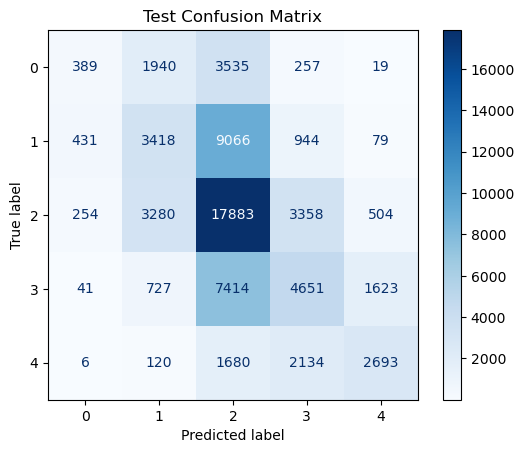

In [15]:
plot_confusion_matrix(metrics['confusion_matrix_test'], metrics['labels'], "Test Confusion Matrix")

In [16]:
reporte.save(metrics, model_name="KNNP")


✅ Report for model 'KNNP' saved:
   → CSV: ./Metrics/Metrics_KNNP.csv
   → JSON: ./Metrics/Metrics_KNNP.json


In [17]:
def plot_roc_multiclass(y_true, y_proba, class_labels, title="AUC-ROC Curve (Multiclass)"):
    # Binarize true labels
    y_bin = label_binarize(y_true, classes=class_labels)
    n_classes = len(class_labels)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i],
                 label=f"Class {class_labels[i]} (AUC = {roc_auc[i]:.3f})")

    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


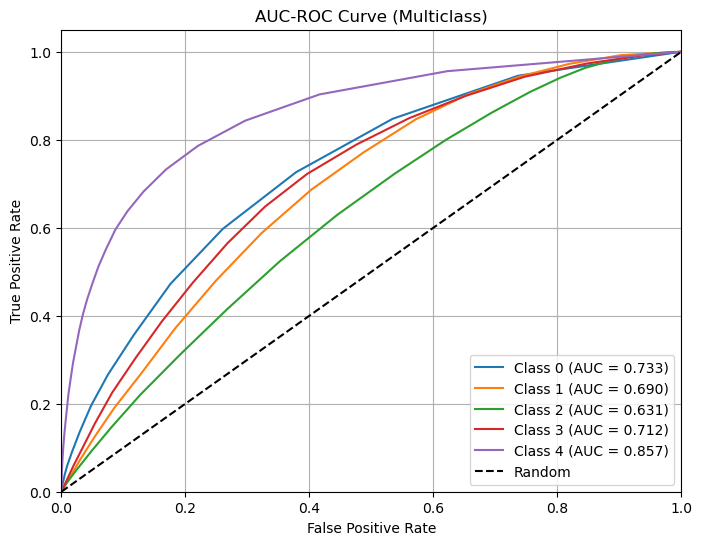

In [18]:
plot_roc_multiclass(
    y_true=metrics["y_test_fold"],
    y_proba=metrics["y_proba_test"],
    class_labels=metrics["labels"]
)

## ***KNN Optimizado***

In [19]:
# ============================
# IMPORTS
# ============================
import os
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, log_loss, roc_auc_score, roc_curve, auc
)
import time
import optuna
from optuna.pruners import MedianPruner
from sklearn.preprocessing import LabelEncoder
from reporte_metricas import ReporteMetricas
reporte = ReporteMetricas()

In [20]:

# =======================
# LOAD DATA
# =======================
file_path = "../Datos_Saber_Pro_Preprocesed.csv"
df = pd.read_csv(file_path)
X = df.drop(columns=["MOD_INGLES_DESEM"])
y = df["MOD_INGLES_DESEM"]

categorical_features = X.select_dtypes(include='object').columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [21]:
le = LabelEncoder()
y = pd.Series(le.fit_transform(y), index=y.index)

class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Class mapping:", class_mapping)

Class mapping: {'-A1': np.int64(0), 'A1': np.int64(1), 'A2': np.int64(2), 'B1': np.int64(3), 'B2': np.int64(4)}


In [22]:
# ============================
model_filename_ = "../Models/best_knn_model_optim.pkl"
metrics_filename_ = "../Models/best_knn_metrics_optim.pkl"
fold_metrics_filename_ = "./Metrics/knn_folds_summary_optim.csv"

In [23]:
# ============================
# OPTUNA INNER CV OPTIMIZATION
# ============================
def run_inner_optuna(X_inner, y_inner, numeric_features, categorical_features, n_trials=75): 
    def objective(trial):
        params = {
            "n_neighbors": trial.suggest_int("n_neighbors", 10, 50, step=5),
            "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
            "metric": trial.suggest_categorical("metric", ["euclidean", "manhattan"]),
            "algorithm": trial.suggest_categorical("algorithm", ["ball_tree", "kd_tree"])
        }

        
        model = build_pipeline(params, numeric_features, categorical_features)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
        scores = []
        
        for train_idx, val_idx in skf.split(X_inner, y_inner):
            X_t, X_v = X_inner.iloc[train_idx], X_inner.iloc[val_idx]
            y_t, y_v = y_inner.iloc[train_idx], y_inner.iloc[val_idx]
            model.fit(X_t, y_t)
            y_pred = model.predict(X_v)
            scores.append(f1_score(y_v, y_pred, average='weighted'))
        return np.mean(scores)

    study = optuna.create_study(direction="maximize", pruner=MedianPruner())
    study.optimize(objective, n_trials=n_trials)
    return study.best_params, study

In [24]:
# ============================
# NESTED CV
# ============================
def nested_cv(X: pd.DataFrame, y: pd.Series, numeric_features: list, categorical_features: list):
    all_folds_metrics_ = []

    if os.path.exists(model_filename_) and os.path.exists(metrics_filename_):
        best_model = joblib.load(model_filename_)
        best_metrics = joblib.load(metrics_filename_)
        return best_model, best_metrics

    optuna_studies = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    best_f1 = -np.inf
    best_model = None
    best_metrics = {}

    for fold, (train_idx, test_idx) in tqdm(enumerate(outer_cv.split(X, y), 1), total=outer_cv.get_n_splits(), desc="Training folds"):
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train_fold, y_train_fold, test_size=0.2, stratify=y_train_fold, random_state=SEED
        )

        start_time = time.time()
        best_params, study = run_inner_optuna(X_tr, y_tr, numeric_features, categorical_features)
        elapsed = time.time() - start_time

        optuna_studies.append(study)

        model = build_pipeline(best_params, numeric_features, categorical_features)
        model.fit(X_tr, y_tr)

        f1_train, acc_train, loss_train, auc_train, report_train, cm_train, y_proba_train, y_train_pred = evaluate_model(model, X_tr, y_tr)
        f1_val, acc_val, loss_val, auc_val, report_val, cm_val, y_proba_val, y_val_pred = evaluate_model(model, X_val, y_val)
        f1_test, acc_test, loss_test, auc_test, report_test, cm_test, y_proba_test, y_test_pred = evaluate_model(model, X_test_fold, y_test_fold)

        fold_metrics = {
            "fold": fold,
            "f1_train": f1_train,
            "accuracy_train": acc_train,
            "log_loss_train": loss_train,
            "auc_train": auc_train,
            "f1_val": f1_val,
            "accuracy_val": acc_val,
            "log_loss_val": loss_val,
            "auc_val": auc_val,
            "f1_test": f1_test,
            "accuracy_test": acc_test,
            "log_loss_test": loss_test,
            "auc_test": auc_test,
            "optuna_time": elapsed
        }
        all_folds_metrics_.append(fold_metrics)

        if f1_test > best_f1:
            best_f1 = f1_test
            best_model = model
            best_metrics = {
                **fold_metrics,
                "params": best_params,
                "labels": np.unique(y),
                "best_fold": fold - 1,
                "X_train_fold": X_tr,
                "y_train_fold": y_tr,
                "y_train_pred": y_train_pred,
                "y_train_true": y_tr,
                "y_proba_train": y_proba_train,
                "classification_report_train": report_train,
                "confusion_matrix_train": cm_train,
                "y_val_true": y_val,
                "y_val_pred": y_val_pred,
                "y_proba_val": y_proba_val,
                "classification_report_val": report_val,
                "confusion_matrix_val": cm_val,
                "y_test_fold": y_test_fold,
                "y_test_pred": y_test_pred,
                "y_proba_test": y_proba_test,
                "classification_report_test": report_test,
                "confusion_matrix_test": cm_test
            }

    joblib.dump(best_model, model_filename_)
    joblib.dump(best_metrics, metrics_filename_)
    df_folds = save_metrics_folds(all_folds_metrics_, fold_metrics_filename_)

    return best_model, best_metrics

In [25]:
model, metrics = nested_cv(X, y, numeric_features, categorical_features)

In [26]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Sin '
                                                                                            'Dato',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=F...
                                                   'ESTU_NACIONALIDAD',
                                                   'ESTU_HORASSEMANATRABAJA',
                                                   'ESTU_PAGOMATRICULABECA',
                                                   'ESTU_PAGOMATRICULACREDITO',
                                                   'ESTU_PAGOMATRICULAPADRES',
                                                   'ESTU_PAGOMATRICULAPROPIO',
                                                   'ESTU_DEPTO_RESIDE',
                                                   'ESTU_DEPTO_PRESENTACION'])],
                                   verbose_feature_names_out=False)),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 KNeighborsClassifier(algorithm='kd_tree', metric='manhattan',
                                      n_neighbors=50))])

In [27]:
print(metrics['classification_report_val'])

              precision    recall  f1-score   support

           0       0.49      0.10      0.17      4912
           1       0.40      0.28      0.33     11151
           2       0.46      0.71      0.56     20223
           3       0.43      0.34      0.38     11565
           4       0.56      0.41      0.47      5306

    accuracy                           0.46     53157
   macro avg       0.47      0.37      0.38     53157
weighted avg       0.45      0.46      0.43     53157



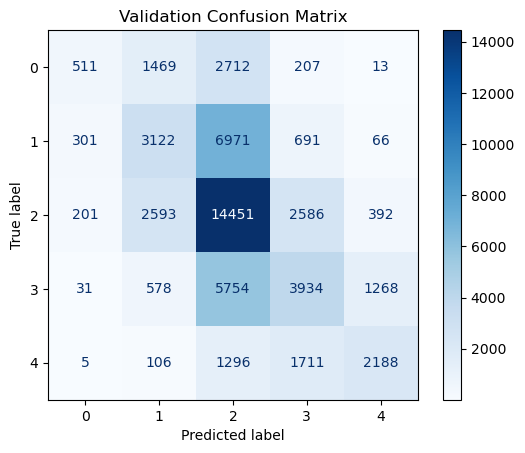

In [28]:
plot_confusion_matrix(metrics['confusion_matrix_val'], metrics['labels'], "Validation Confusion Matrix")

In [29]:
print(metrics['classification_report_test'])

              precision    recall  f1-score   support

           0       0.50      0.11      0.19      6140
           1       0.41      0.29      0.34     13938
           2       0.47      0.72      0.57     25279
           3       0.45      0.36      0.40     14456
           4       0.58      0.44      0.50      6633

    accuracy                           0.47     66446
   macro avg       0.48      0.38      0.40     66446
weighted avg       0.47      0.47      0.44     66446



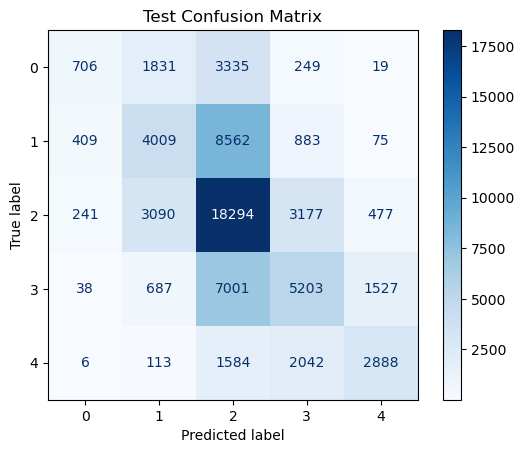

In [30]:
plot_confusion_matrix(metrics['confusion_matrix_test'], metrics['labels'], "Test Confusion Matrix")

In [31]:
reporte.save(metrics, model_name="KNN_OPT")


✅ Report for model 'KNN_OPT' saved:
   → CSV: ./Metrics/Metrics_KNN_OPT.csv
   → JSON: ./Metrics/Metrics_KNN_OPT.json


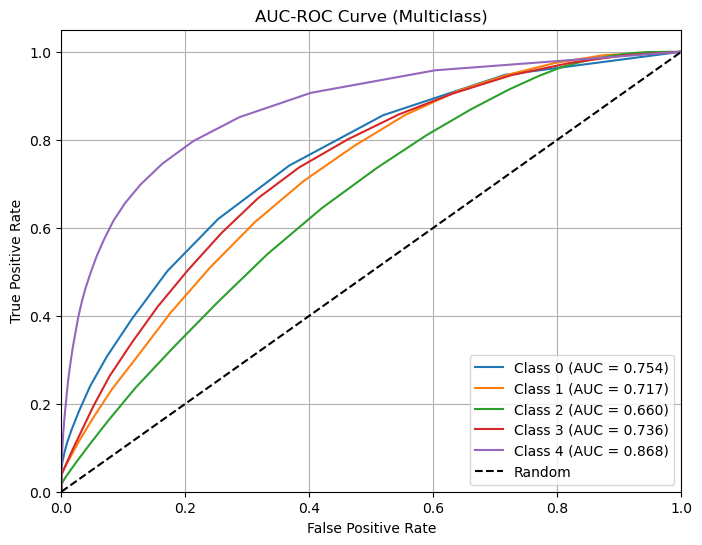

In [32]:
plot_roc_multiclass(
    y_true=metrics["y_test_fold"],
    y_proba=metrics["y_proba_test"],
    class_labels=metrics["labels"]
)

In [33]:
model.named_steps['classifier'].get_params()

{'algorithm': 'kd_tree',
 'leaf_size': 30,
 'metric': 'manhattan',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 50,
 'p': 2,
 'weights': 'uniform'}

In [34]:
folds_knn = pd.read_csv(fold_metrics_filename)
folds_knn

,fold,f1_train,accuracy_train,log_loss_train,auc_train,f1_val,accuracy_val,log_loss_val,auc_val,f1_test,accuracy_test,log_loss_test,auc_test,optuna_time
0,1,0.455,0.483,1.165,0.754,0.405,0.435,1.703,0.694,0.406,0.437,1.698,0.693,7939.092
1,2,0.453,0.482,1.165,0.753,0.407,0.438,1.681,0.695,0.404,0.435,1.681,0.692,22682.272
2,3,0.462,0.488,1.152,0.758,0.402,0.430,1.816,0.689,0.405,0.433,1.833,0.691,24633.440
3,4,0.454,0.483,1.166,0.753,0.400,0.432,1.674,0.691,0.405,0.436,1.697,0.693,21405.370
4,5,0.454,0.484,1.166,0.753,0.402,0.434,1.685,0.694,0.400,0.432,1.683,0.693,6898.265
5,mean,0.455,0.484,1.163,0.754,0.403,0.434,1.712,0.693,0.404,0.435,1.718,0.692,16711.688
6,std,0.004,0.002,0.006,0.002,0.003,0.003,0.059,0.003,0.002,0.002,0.065,0.001,8568.757


In [35]:
folds_knn_opt = pd.read_csv(fold_metrics_filename_)
folds_knn_opt

,fold,f1_train,accuracy_train,log_loss_train,auc_train,f1_val,accuracy_val,log_loss_val,auc_val,f1_test,accuracy_test,log_loss_test,auc_test,optuna_time
0,1,0.464,0.489,1.205,0.762,0.413,0.447,1.732,0.719,0.424,0.454,1.758,0.717,6990.612
1,2,0.474,0.502,1.180,0.790,0.416,0.444,1.759,0.719,0.409,0.453,1.720,0.700,18845.662
2,3,0.474,0.494,1.198,0.771,0.418,0.446,1.897,0.721,0.415,0.439,1.890,0.717,21857.006
3,4,0.465,0.493,1.190,0.781,0.404,0.444,1.742,0.704,0.425,0.455,1.778,0.708,19008.740
4,5,0.463,0.505,1.206,0.766,0.414,0.441,1.731,0.703,0.420,0.438,1.735,0.726,5643.386
5,mean,0.468,0.496,1.196,0.774,0.413,0.444,1.772,0.713,0.419,0.448,1.776,0.714,14469.081
6,std,0.006,0.007,0.011,0.012,0.005,0.002,0.071,0.009,0.007,0.009,0.067,0.010,7552.562
